
# Project 29 — Sentiment Analysis of Hotel Reviews (London subset)

This notebook implements **Steps 1–13** for the project specification using the 515K European hotel reviews dataset,
filtered to London by default. It produces a per‑review database **D1** and visualizations, and includes a **simple GUI** to run steps.

> **Notes**
> - If **SentiStrength** or **Harvard Inquirer** files are not configured, the notebook falls back to safe, documented alternatives (VADER and a tiny seed list) so everything still runs. You can plug the real resources later for 1:1 reproduction.
> - The notebook writes outputs to `./project_29_outputs/`.


## 0. Setup & Dependencies

In [1]:

# Optional: install deps if missing (uncomment to use inside Jupyter)
# %pip install pandas numpy matplotlib nltk wordcloud gensim empath regex scipy ipywidgets tqdm

import os, re, json, subprocess, math, warnings, itertools, textwrap
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer  # VADER fallback

# LDA
from gensim import corpora, models
from wordcloud import WordCloud

# Empath
try:
    from empath import Empath
    empath_available = True
except Exception:
    empath_available = False
    warnings.warn("Empath not available. Step 7–10 will use a fallback (empty results). Install 'empath'.")

# Widgets (simple GUI)
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    widgets_available = True
except Exception:
    widgets_available = False
    warnings.warn("ipywidgets not available; GUI will be skipped.")

# NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('vader_lexicon', quiet=True)

plt.rcParams['figure.figsize'] = (8,5)
warnings.filterwarnings("ignore")


## 1. Configuration

In [2]:

# ---- Paths ----
DATA_PATH = "/Users/noman/Desktop/Hotel_Reviews.csv"   # <-- Confirm this path for your environment
OUTPUT_DIR = "./project_29_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# SentiStrength (Step 1): set these to your local paths to use SentiStrength instead of VADER
SENTISTRENGTH_JAR = ""        # e.g. "/Users/me/SentiStrengthCom.jar"
SENTIDATA_DIR      = ""        # e.g. "/Users/me/SentStrength_Data/"
# Harvard General Inquirer (Step 12)
INQUIRER_XLS = ""             # e.g. "/Users/me/inquirerbasic.xls"

# ---- Filters & thresholds ----
CITY_FILTER = "London"         # Set to None to use all reviews
STAR_FROM_TAGS_PATTERN = r'(\d+)\s*star'

STD_EPSILON_STRATEGY = "q75"   # 'q75' or 'fixed'
STD_EPSILON_FIXED = 1.0

RATING_NEGATIVE_MAX = 5.0      # <= negative
RATING_POSITIVE_MIN = 8.0      # >= positive

# WordCloud / LDA
TOP_N_WORDS_WORDCLOUD = 150
LDA_NUM_TOPICS = 5
LDA_WORDS_PER_TOPIC = 5

# Optional sampling to speed up experimentation (set to None for full data)
SAMPLE_MAX_ROWS = None  # e.g. 50_000

# Seed
SEED = 42
np.random.seed(SEED)


## 2. Helper Functions

In [3]:

def clean_text(s):
    if not isinstance(s, str): return ""
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def combine_review_row(row):
    parts = []
    p = row.get('Positive_Review', '')
    n = row.get('Negative_Review', '')
    if isinstance(p, str) and p.lower() != "no positive": parts.append(p)
    if isinstance(n, str) and n.lower() != "no negative": parts.append(n)
    if not parts:
        if isinstance(row.get('Positive_Review',''), str): parts.append(row['Positive_Review'])
        if isinstance(row.get('Negative_Review',''), str): parts.append(row['Negative_Review'])
    return " ".join([x for x in parts if isinstance(x, str)])

def extract_stars_from_tags(tags):
    if not isinstance(tags, str): return np.nan
    m = re.search(STAR_FROM_TAGS_PATTERN, tags.lower())
    if m:
        try: return float(m.group(1))
        except: return np.nan
    return np.nan

def compute_pearson(x, y):
    x = pd.Series(x).astype(float)
    y = pd.Series(y).astype(float)
    return x.corr(y, method='pearson')

def choose_std_epsilon(std_series, strategy="q75", fixed=1.0):
    std_series = pd.Series(std_series).dropna()
    if strategy == "fixed": return fixed
    return float(std_series.quantile(0.75))

def label_rating_polarity(r):
    if pd.isna(r): return "neutral"
    if r <= RATING_NEGATIVE_MAX: return "negative"
    if r >= RATING_POSITIVE_MIN: return "positive"
    return "neutral"

def build_corpus(texts):
    stop = set(stopwords.words('english'))
    processed = [ [w for w in word_tokenize(clean_text(t)) if w not in stop and len(w)>2] for t in texts ]
    dictionary = corpora.Dictionary(processed)
    corpus = [ dictionary.doc2bow(doc) for doc in processed ]
    return processed, dictionary, corpus

def lda_topics(texts, num_topics=5, words_per_topic=5, passes=5):
    if not texts:
        return []
    processed, dictionary, corpus = build_corpus(texts)
    if len(dictionary) == 0 or len(corpus) == 0:
        return []
    lda = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=SEED, passes=passes)
    topics = []
    for _tid, topic in lda.show_topics(num_topics=num_topics, num_words=words_per_topic, formatted=False):
        words = [w for w,_ in topic]
        topics.append(words)
    return topics

def empath_categories_for_text(text):
    if not empath_available:
        return {}
    lex = Empath()
    return lex.analyze(text or "", normalize=False)

def top_words(texts, n=150):
    stop = set(stopwords.words('english'))
    counts = Counter()
    for t in texts:
        for w in word_tokenize(clean_text(t)):
            if w not in stop and len(w)>2:
                counts[w]+=1
    return [w for w,_ in counts.most_common(n)], counts

def draw_wordcloud(texts, title="WordCloud"):
    text = " ".join(texts)
    wc = WordCloud(width=1000, height=600, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title)
    plt.show()

def ontology_seed():
    return {
        "Price":   {"price","cost","expensive","cheap","value","deal","charge","fee","budget","afford","rate"},
        "Service": {"service","staff","manager","reception","helpful","rude","friendly","checkin","checkout","wait","attentive"},
        "Parking": {"parking","carpark","garage","valet","park","space"},
        "Room":    {"room","bed","bathroom","clean","dirty","size","spacious","view","noise","quiet","amenity","tv","ac","aircon"},
        "Location":{"location","close","near","walk","distance","metro","tube","bus","station","central","area","neighborhood"},
        "Food":    {"breakfast","dinner","lunch","food","restaurant","bar","coffee","tea","buffet","menu","taste"}
    }

def count_ontology(texts, ontology):
    counts = {k:0 for k in ontology}
    for t in texts:
        tokens = set(word_tokenize(clean_text(t)))
        for cat, words in ontology.items():
            if tokens & words:
                counts[cat]+=1
    return counts

def load_inquirer_adjectives(xls_path):
    if not xls_path or not os.path.exists(xls_path):
        warnings.warn("Harvard Inquirer XLS not found — using a small fallback sentiment adjective/adverb list.")
        pos_adj_adv = {"good","excellent","amazing","friendly","clean","spacious","fast"}
        neg_adj_adv = {"bad","terrible","awful","rude","dirty","small","slow"}
        return pos_adj_adv, neg_adj_adv
    df = pd.read_excel(xls_path)
    cols = {c.lower(): c for c in df.columns}
    entry_col = cols.get('entry', list(df.columns)[0])
    pos_cols = [c for c in df.columns if str(c).lower() in ('positiv','pstv','pos')]
    neg_cols = [c for c in df.columns if str(c).lower() in ('negativ','ngtv','neg')]
    adj_cols = [c for c in df.columns if str(c).lower() in ('adj','adjective')]
    adv_cols = [c for c in df.columns if str(c).lower() in ('adv','adverb','iav')]
    pos_mask = df[pos_cols].fillna("").astype(str).apply(lambda r: any(v.strip() in ('Positiv','Pstv','1') for v in r), axis=1) if pos_cols else pd.Series(False, index=df.index)
    neg_mask = df[neg_cols].fillna("").astype(str).apply(lambda r: any(v.strip() in ('Negativ','Ngtv','1') for v in r), axis=1) if neg_cols else pd.Series(False, index=df.index)
    aa_mask  = df[adj_cols+adv_cols].notna().any(axis=1) if (adj_cols or adv_cols) else pd.Series(True, index=df.index)
    pos_adj_adv = set(df.loc[pos_mask & aa_mask, entry_col].astype(str).str.lower().str.strip())
    neg_adj_adv = set(df.loc[neg_mask & aa_mask, entry_col].astype(str).str.lower().str.strip())
    pos_adj_adv = {re.sub(r'[^a-z]+','',w) for w in pos_adj_adv if re.sub(r'[^a-z]+','',w)}
    neg_adj_adv = {re.sub(r'[^a-z]+','',w) for w in neg_adj_adv if re.sub(r'[^a-z]+','',w)}
    return pos_adj_adv, neg_adj_adv

def noun_associations_for_adj_adv(texts, target_words, window=2):
    results = defaultdict(Counter)
    for t in texts:
        tokens = word_tokenize(t)
        pos = nltk.pos_tag(tokens)
        for i,(tok, tag) in enumerate(pos):
            w = tok.lower()
            if w in target_words:
                chosen = None
                for j in range(i-1, max(i-window-1, -1), -1):
                    if pos[j][1].startswith("NN"):
                        chosen = pos[j][0].lower(); break
                if not chosen:
                    for j in range(i+1, min(i+window+1, len(pos))):
                        if pos[j][1].startswith("NN"):
                            chosen = pos[j][0].lower(); break
                if chosen:
                    results[w][chosen]+=1
    return {w: dict(cnt) for w,cnt in results.items()}

def proportion_hist(proportions, title, xlabel, ylabel="Proportion"):
    plt.figure()
    plt.bar(list(proportions.keys()), list(proportions.values()))
    plt.title(title); plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.xticks(rotation=45); plt.tight_layout(); plt.show()


## 3. Load & Prepare Data

In [4]:

df = pd.read_csv(DATA_PATH, nrows=SAMPLE_MAX_ROWS)
print("Loaded rows:", len(df))

if CITY_FILTER:
    mask = df.get("Hotel_Address","").astype(str).str.contains(CITY_FILTER, case=False, na=False) |            df.get("Hotel_Name","").astype(str).str.contains(CITY_FILTER, case=False, na=False)
    df = df.loc[mask].copy()
    print(f"Filtered to city '{CITY_FILTER}': {len(df)} rows")

df["review_text"] = df.apply(combine_review_row, axis=1)

if "Tags" in df.columns:
    df["Stars"] = df["Tags"].astype(str).apply(extract_stars_from_tags)
else:
    df["Stars"] = np.nan

keep_cols = ["Hotel_Name","Hotel_Address","Reviewer_Score","Tags","Stars","Positive_Review","Negative_Review","review_text"]
df = df[keep_cols]
df.rename(columns={"Reviewer_Score":"user_rating"}, inplace=True)
df.head(2)


Loaded rows: 515738
Filtered to city 'London': 262301 rows


,Hotel_Name,Hotel_Address,user_rating,Tags,Stars,Positive_Review,Negative_Review,review_text
405,K K Hotel George,1 15 Templeton Place Earl s Court Kensington a...,9.6,"[' Leisure trip ', ' Group ', ' Classic Twin R...",NaN,Very comfortable beds smart bathroom good sho...,Really nothing negative to say about this hotel,Very comfortable beds smart bathroom good sho...
406,K K Hotel George,1 15 Templeton Place Earl s Court Kensington a...,7.1,"[' Leisure trip ', ' Couple ', ' Classic Twin ...",NaN,No Positive,No coffee or tea in the room or lobby No one ...,No coffee or tea in the room or lobby No one ...


## 4. Step 1 — SentiStrength (or VADER fallback) → D1

In [5]:

def run_sentistrength_on_texts(texts, jar_path, data_dir):
    if not jar_path or not data_dir or not os.path.exists(jar_path) or not os.path.isdir(data_dir):
        sia = SentimentIntensityAnalyzer()
        pos, neg, overall = [], [], []
        for t in texts:
            s = sia.polarity_scores(t or "")
            comp = s['compound']
            p = int(np.clip(round((comp+1)*2), 1, 5))  # map to 1..5
            n = -int(np.clip(round((1-comp)*2), 1, 5)) # map to -1..-5
            pos.append(p); neg.append(n); overall.append(p+n)
        df = pd.DataFrame({"ss_pos": pos, "ss_neg": neg, "ss_overall": overall})
        df.attrs["engine"] = "VADER (fallback — configure SentiStrength for exact reproduction)"
        return df

    cmd = ["java", "-jar", jar_path, "sentidata", data_dir, "stdin"]
    proc = subprocess.Popen(cmd, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    for t in texts:
        proc.stdin.write((t or "") + "\n")
    proc.stdin.close()
    stdout, stderr = proc.communicate()
    if stderr:
        print("SentiStrength stderr:", stderr)
    out_lines = [ln.strip() for ln in stdout.strip().splitlines() if ln.strip()]
    pos, neg, overall = [], [], []
    for ln in out_lines:
        parts = ln.split()
        p = int(parts[0]); n = int(parts[1]) if len(parts)>1 else 0
        pos.append(p); neg.append(n); overall.append(p+n)
    df = pd.DataFrame({"ss_pos": pos, "ss_neg": neg, "ss_overall": overall})
    df.attrs["engine"] = "SentiStrength"
    return df

texts = df["review_text"].fillna("").tolist()
ss_df = run_sentistrength_on_texts(texts, jar_path=SENTISTRENGTH_JAR, data_dir=SENTIDATA_DIR)
print("Sentiment engine:", ss_df.attrs.get("engine","unknown"))

D1 = pd.concat([df.reset_index(drop=True), ss_df], axis=1)
D1["ss_overall"] = D1["ss_pos"].astype(int) + D1["ss_neg"].astype(int)
D1_path = os.path.join(OUTPUT_DIR, "D1_step1_sentiment.csv")
D1.to_csv(D1_path, index=False)
print("Saved:", D1_path)

import sqlite3

# Create SQLite DB file
db_path = os.path.join(OUTPUT_DIR, "D1_step1_sentiment.db")

# Open connection (creates file if missing)
conn = sqlite3.connect(db_path)

# Write DataFrame to SQLite table named 'reviews'
D1.to_sql("reviews", conn, if_exists="replace", index=False)

# Close the connection
conn.close()

print("Saved database:", db_path)

D1.head(3)


Sentiment engine: VADER (fallback — configure SentiStrength for exact reproduction)
Saved: ./project_29_outputs/D1_step1_sentiment.csv
Saved database: ./project_29_outputs/D1_step1_sentiment.db


,Hotel_Name,Hotel_Address,user_rating,Tags,Stars,Positive_Review,Negative_Review,review_text,ss_pos,ss_neg,ss_overall
0,K K Hotel George,1 15 Templeton Place Earl s Court Kensington a...,9.6,"[' Leisure trip ', ' Group ', ' Classic Twin R...",NaN,Very comfortable beds smart bathroom good sho...,Really nothing negative to say about this hotel,Very comfortable beds smart bathroom good sho...,4,-1,3
1,K K Hotel George,1 15 Templeton Place Earl s Court Kensington a...,7.1,"[' Leisure trip ', ' Couple ', ' Classic Twin ...",NaN,No Positive,No coffee or tea in the room or lobby No one ...,No coffee or tea in the room or lobby No one ...,1,-3,-2
2,K K Hotel George,1 15 Templeton Place Earl s Court Kensington a...,9.2,"[' Leisure trip ', ' Family with young childre...",NaN,The staff was very friendly and helpful in or...,Room was pretty small for the three of us,The staff was very friendly and helpful in or...,4,-1,3


## 5. Step 2 — Pearson correlation: overall sentiment vs user rating

In [6]:

pearson = compute_pearson(D1["ss_overall"], D1["user_rating"])
print("Pearson correlation (overall vs user_rating):", round(float(pearson), 4))


Pearson correlation (overall vs user_rating): 0.4764


## 6. Step 3 — By-hotel stats & Ambiguous class threshold

In [7]:

agg = D1.groupby("Hotel_Name")["user_rating"].agg(
    avg_rating="mean",
    std_rating="std",
    kurt_rating=pd.Series.kurt
).reset_index()

epsilon = choose_std_epsilon(agg["std_rating"], strategy=STD_EPSILON_STRATEGY, fixed=STD_EPSILON_FIXED)
print("STD epsilon (threshold):", round(epsilon,3))

stars_by_hotel = D1.groupby("Hotel_Name")["Stars"].median().rename("Stars")
agg = agg.merge(stars_by_hotel, on="Hotel_Name", how="left")

print("Low std hotels (sample):")
display(agg.nsmallest(10, "std_rating")[["Hotel_Name","std_rating","avg_rating","Stars"]])
print("High std hotels (sample):")
display(agg.nlargest(10, "std_rating")[["Hotel_Name","std_rating","avg_rating","Stars"]])


agg_path = os.path.join(OUTPUT_DIR, "by_hotel_stats.csv")
agg.to_csv(agg_path, index=False)
print("Saved:", agg_path)




STD epsilon (threshold): 1.674
Low std hotels (sample):


,Hotel_Name,std_rating,avg_rating,Stars
2,45 Park Lane Dorchester Collection,0.564035,9.603571,NaN
1,41,0.590497,9.711650,NaN
171,Lansbury Heritage Hotel,0.655113,9.517500,NaN
57,Covent Garden Hotel,0.668253,9.587838,NaN
367,The Soho Hotel,0.668806,9.597452,NaN
199,Milestone Hotel Kensington,0.693610,9.572093,NaN
116,Haymarket Hotel,0.737789,9.590909,NaN
382,The Zetter Townhouse Marylebone,0.748859,9.391463,NaN
299,The Beaumont Hotel,0.757372,9.490833,NaN
35,Bulgari Hotel London,0.771674,9.529730,NaN


High std hotels (sample):


,Hotel_Name,std_rating,avg_rating,Stars
370,The Tophams Hotel,2.111855,6.480000,NaN
273,Simply Rooms Suites,2.074223,7.639130,NaN
50,Commodore Hotel,2.054648,6.554355,NaN
114,Hallmark Hotel London Chigwell Prince Regent,2.036328,6.566955,NaN
34,Britannia International Hotel Canary Wharf,2.025480,6.826644,NaN
119,Henry VIII,2.019633,6.785095,NaN
23,Best Western Maitrise Hotel Edgware Road,2.015026,6.375000,NaN
111,Grosvenor House A JW Marriott Hotel,2.012015,7.765164,NaN
147,Hotel Cavendish,1.995567,6.442065,NaN
391,United Lodge Hotel and Apartments,1.990045,7.383857,NaN


Saved: ./project_29_outputs/by_hotel_stats.csv


## 7. Step 4 — Ambiguous Class & Subclasses

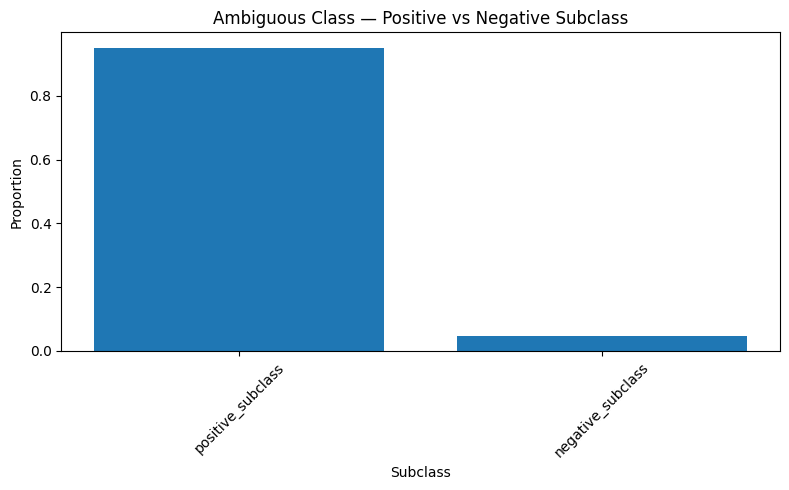

Saved: ./project_29_outputs/D1_with_ambiguous.csv


In [8]:

ambiguous_hotels = set(agg.loc[agg["std_rating"]>epsilon, "Hotel_Name"])

D1["rating_polarity"] = D1["user_rating"].apply(label_rating_polarity)

def majority_subclass(g):
    counts = g["rating_polarity"].value_counts()
    neg = counts.get("negative",0); pos = counts.get("positive",0)
    if pos > neg: return "positive_subclass"
    elif neg > pos: return "negative_subclass"
    else: return "tie"

maj = D1[D1["Hotel_Name"].isin(ambiguous_hotels)].groupby("Hotel_Name").apply(majority_subclass).rename("Ambig_Subclass")
maj = maj.reset_index()

D1 = D1.merge(maj, on="Hotel_Name", how="left")
D1["Ambiguous_Class"] = D1["Hotel_Name"].apply(lambda h: "Ambiguous" if h in ambiguous_hotels else "NotAmbiguous")
D1["Ambig_Subclass"] = D1["Ambig_Subclass"].fillna("N/A")

subprop = D1[D1["Ambiguous_Class"]=="Ambiguous"]["Ambig_Subclass"].value_counts(normalize=True)
proportion_hist(subprop.to_dict(), title="Ambiguous Class — Positive vs Negative Subclass", xlabel="Subclass")

D1_path2 = os.path.join(OUTPUT_DIR, "D1_with_ambiguous.csv")
D1.to_csv(D1_path2, index=False)
print("Saved:", D1_path2)


## 8. Step 5 — WordClouds (positive vs negative subclass)

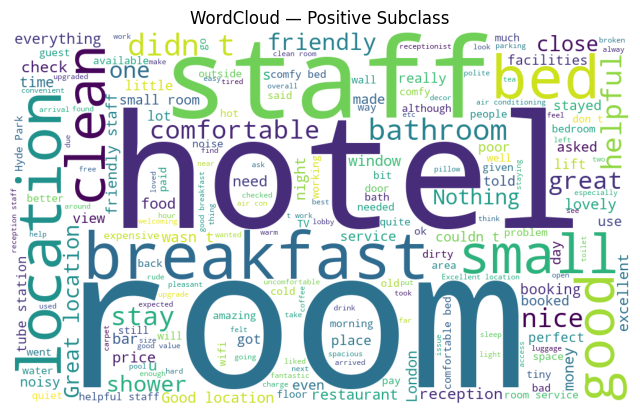

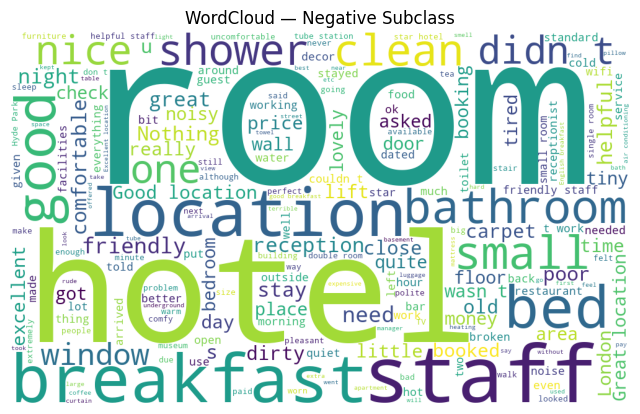

In [9]:

pos_texts = D1[(D1["Ambiguous_Class"]=="Ambiguous") & (D1["Ambig_Subclass"]=="positive_subclass")]["review_text"].tolist()
neg_texts = D1[(D1["Ambiguous_Class"]=="Ambiguous") & (D1["Ambig_Subclass"]=="negative_subclass")]["review_text"].tolist()

if pos_texts: draw_wordcloud(pos_texts, "WordCloud — Positive Subclass")
else: print("No positive subclass texts found.")

if neg_texts: draw_wordcloud(neg_texts, "WordCloud — Negative Subclass")
else: print("No negative subclass texts found.")

pos_top_words, pos_counts = top_words(pos_texts, n=TOP_N_WORDS_WORDCLOUD)
neg_top_words, neg_counts = top_words(neg_texts, n=TOP_N_WORDS_WORDCLOUD)

pd.Series(pos_top_words, name="positive_top_words").to_csv(os.path.join(OUTPUT_DIR,"positive_top_words.csv"), index=False)
pd.Series(neg_top_words, name="negative_top_words").to_csv(os.path.join(OUTPUT_DIR,"negative_top_words.csv"), index=False)


## 9. Step 6 — LDA topics & overlap with WordCloud

In [10]:

pos_topics = lda_topics(pos_texts, num_topics=LDA_NUM_TOPICS, words_per_topic=LDA_WORDS_PER_TOPIC)
neg_topics = lda_topics(neg_texts, num_topics=LDA_NUM_TOPICS, words_per_topic=LDA_WORDS_PER_TOPIC)
print("Positive subclass topics:", pos_topics)
print("Negative subclass topics:", neg_topics)

with open(os.path.join(OUTPUT_DIR,"lda_topics.json"), "w") as f:
    json.dump({"positive": pos_topics, "negative": neg_topics}, f, indent=2)

def lda_word_set(topics):
    s=set()
    for t in topics: s.update(t)
    return s

pos_lda_words = lda_word_set(pos_topics)
neg_lda_words = lda_word_set(neg_topics)
print("Overlap POS (LDA vs WC): ", len(pos_lda_words & set(pos_top_words)), " / ", len(pos_lda_words or []))
print("Overlap NEG (LDA vs WC): ", len(neg_lda_words & set(neg_top_words)), " / ", len(neg_lda_words or []))


Positive subclass topics: [['room', 'hotel', 'staff', 'one', 'would'], ['location', 'hotel', 'tube', 'close', 'staff'], ['room', 'location', 'staff', 'good', 'small'], ['room', 'bed', 'shower', 'bathroom', 'small'], ['breakfast', 'bar', 'service', 'staff', 'free']]
Negative subclass topics: [['breakfast', 'staff', 'hotel', 'room', 'good'], ['room', 'staff', 'breakfast', 'hotel', 'location'], ['room', 'location', 'staff', 'bed', 'good'], ['location', 'staff', 'good', 'room', 'friendly'], ['room', 'hotel', 'would', 'nothing', 'bed']]
Overlap POS (LDA vs WC):  17  /  17
Overlap NEG (LDA vs WC):  10  /  10


## 10. Steps 7–10 — Empath & Agreement Ratios

In [11]:

def nonzero_empath_categories(texts):
    if not empath_available or not texts:
        return {}
    text = " ".join(texts)
    cats = empath_categories_for_text(text)
    return {k:v for k,v in cats.items() if v and v>0}

pos_empath = nonzero_empath_categories(pos_texts)
neg_empath = nonzero_empath_categories(neg_texts)

with open(os.path.join(OUTPUT_DIR,"empath_nonzero.json"), "w") as f:
    json.dump({"positive": pos_empath, "negative": neg_empath}, f, indent=2)

def ratio_overlap_empath_vs_words(empath_cats, word_set):
    if not empath_cats: return 0.0
    cat_tokens = set(itertools.chain.from_iterable([k.split("_") for k in empath_cats.keys()]))
    inter = cat_tokens & word_set
    return len(inter)/max(1,len(cat_tokens))

pos_agree_wc = ratio_overlap_empath_vs_words(pos_empath, set(pos_top_words))
neg_agree_wc = ratio_overlap_empath_vs_words(neg_empath, set(neg_top_words))

def ratio_overlap_empath_vs_lda(empath_cats, lda_words):
    if not empath_cats: return 0.0
    cat_tokens = set(itertools.chain.from_iterable([k.split("_") for k in empath_cats.keys()]))
    inter = cat_tokens & lda_words
    return len(inter)/max(1,len(cat_tokens))

pos_agree_lda = ratio_overlap_empath_vs_lda(pos_empath, pos_lda_words)
neg_agree_lda = ratio_overlap_empath_vs_lda(neg_empath, neg_lda_words)

print("Agreement (Empath vs WordCloud) — POS:", round(pos_agree_wc,3), "NEG:", round(neg_agree_wc,3))
print("Agreement (Empath vs LDA)       — POS:", round(pos_agree_lda,3), "NEG:", round(neg_agree_lda,3))

# Record summaries in D1 for subclass rows
D1["Empath_nonzero_count"] = np.where(D1["Ambig_Subclass"]=="positive_subclass", len(pos_empath),
                                np.where(D1["Ambig_Subclass"]=="negative_subclass", len(neg_empath), np.nan))
D1["Agree_Empath_WC"] = np.where(D1["Ambig_Subclass"]=="positive_subclass", pos_agree_wc,
                           np.where(D1["Ambig_Subclass"]=="negative_subclass", neg_agree_wc, np.nan))
D1["Agree_Empath_LDA"] = np.where(D1["Ambig_Subclass"]=="positive_subclass", pos_agree_lda,
                           np.where(D1["Ambig_Subclass"]=="negative_subclass", neg_agree_lda, np.nan))

D1_path3 = os.path.join(OUTPUT_DIR, "D1_with_empath.csv")
D1.to_csv(D1_path3, index=False)
print("Saved:", D1_path3)


Agreement (Empath vs WordCloud) — POS: 0.059 NEG: 0.064
Agreement (Empath vs LDA)       — POS: 0.0 NEG: 0.0
Saved: ./project_29_outputs/D1_with_empath.csv


## 11. Step 11 — Ontology Histogram (Price, Service, Parking, Room, Location, Food)

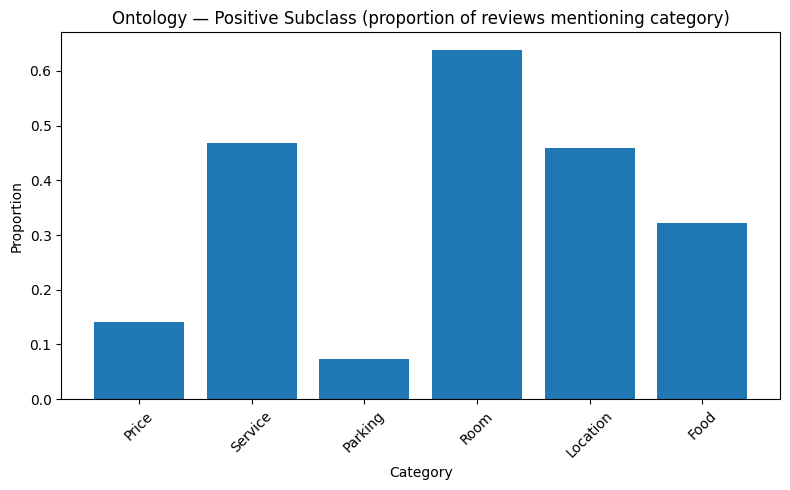

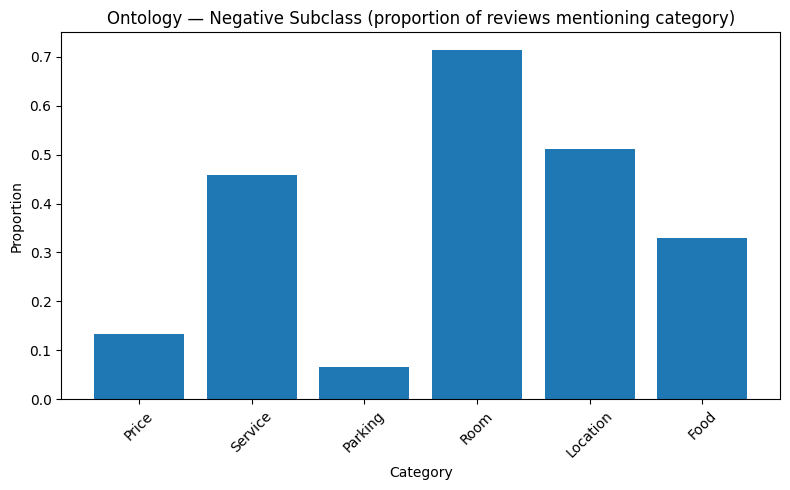

In [12]:

ontology = ontology_seed()
pos_counts = count_ontology(pos_texts, ontology)
neg_counts = count_ontology(neg_texts, ontology)

def normalize(counts, total):
    return {k: (v/max(1,total)) for k,v in counts.items()}

pos_prop = normalize(pos_counts, len(pos_texts))
neg_prop = normalize(neg_counts, len(neg_texts))

proportion_hist(pos_prop, "Ontology — Positive Subclass (proportion of reviews mentioning category)", "Category")
proportion_hist(neg_prop, "Ontology — Negative Subclass (proportion of reviews mentioning category)", "Category")

pd.DataFrame([pos_counts, neg_counts], index=["positive","negative"]).to_csv(os.path.join(OUTPUT_DIR,"ontology_counts.csv"))


## 12. Steps 12–13 — Harvard Inquirer & Noun Associations

In [13]:

pos_adj_adv, neg_adj_adv = load_inquirer_adjectives(INQUIRER_XLS)

pos_nouns = noun_associations_for_adj_adv(pos_texts, pos_adj_adv, window=2)
neg_nouns = noun_associations_for_adj_adv(neg_texts, neg_adj_adv, window=2)

with open(os.path.join(OUTPUT_DIR,"adj_adv_noun_associations.json"), "w") as f:
    json.dump({"positive": pos_nouns, "negative": neg_nouns}, f, indent=2)

print("Top examples (positive):", list(itertools.islice(pos_nouns.items(), 5)))
print("Top examples (negative):", list(itertools.islice(neg_nouns.items(), 5)))

comment = []
comment.append(f"Pearson corr between overall (SentiStrength/VADER) and user rating was computed earlier.")
comment.append(f"Ambiguous hotels threshold epsilon={round(choose_std_epsilon(D1.groupby('Hotel_Name')['user_rating'].std(), STD_EPSILON_STRATEGY, STD_EPSILON_FIXED),3)}.")
comment.append("Adj/adv-to-noun associations may reveal which aspects (e.g., 'service', 'room') are modified by sentiment words.")
comment_path = os.path.join(OUTPUT_DIR, "notes_findings.txt")
open(comment_path,"w").write("\n".join(comment))
print('Saved notes to', comment_path)


Top examples (positive): [('clean', {'bathroom': 216, 'hotel': 513, 'sheets': 17, 'staff': 495, 'location': 425, 'very': 239, 'tube': 8, 'room': 1668, 'dirty': 6, 'beds': 60, 'waterboiler': 1, 'really': 12, 'shower': 44, 'good': 36, 'everything': 68, 'water': 8, 'heathrow': 2, 'nice': 103, 'simplistic': 1, 'size': 47, 'rooms': 538, 'place': 36, 'tidy': 93, 'facilities': 42, 'space': 10, 'floor': 8, 'cleaning': 3, 'looks': 2, 'london': 17, 'suite': 2, 'extra': 2, 'walking': 1, 'street': 7, 'staffs': 5, 'best': 1, 'quilts': 1, 'wifi': 14, 'toilet': 22, 'station': 34, 'comfy': 80, 'towels': 52, 'hard': 1, 'money': 23, 'design': 7, 'will': 4, 'wasn': 24, 'food': 21, 'modern': 38, 'value': 11, 'breakfast': 127, 'a': 11, 'area': 23, 'no': 22, 'stuff': 4, 'spotlessly': 9, 'teeth': 3, 't': 54, 'lobby': 7, 'immaculately': 1, 'furniture': 13, 'variety': 1, 'light': 2, 'bed': 151, 'paint': 2, 'redecoration': 1, 'photos': 1, 'comfort': 9, 'porters': 1, 'service': 27, 'requests': 1, 'basement': 1, 

## 13. Save Final D1

In [14]:

final_path = os.path.join(OUTPUT_DIR, "D1_final.csv")
D1.to_csv(final_path, index=False)
print("Saved final D1 to:", final_path)
try:
    from IPython.display import display
    display(D1.sample(min(5, len(D1))))
except Exception as e:
    print(D1.head())


Saved final D1 to: ./project_29_outputs/D1_final.csv


,Hotel_Name,Hotel_Address,user_rating,Tags,Stars,Positive_Review,Negative_Review,review_text,ss_pos,ss_neg,ss_overall,rating_polarity,Ambig_Subclass,Ambiguous_Class,Empath_nonzero_count,Agree_Empath_WC,Agree_Empath_LDA
174519,Clayton Hotel Chiswick,626 Chiswick High St Chiswick London W4 5RY Un...,6.3,"[' Leisure trip ', ' Group ', ' Deluxe Double ...",NaN,Bar reception and eating areas very good and ...,Breakfast certain types of food running out H...,Bar reception and eating areas very good and ...,3,-1,2,neutral,N/A,NotAmbiguous,NaN,NaN,NaN
185442,DoubleTree by Hilton Hotel London Tower of London,7 Pepys Street City of London London EC3N 4AF ...,10.0,"[' Business trip ', ' Couple ', ' Executive Qu...",NaN,Amazing hotel cater for your every whim thank...,No Negative,Amazing hotel cater for your every whim thank...,4,-1,3,positive,N/A,NotAmbiguous,NaN,NaN,NaN
245892,Copthorne Tara Hotel London Kensington,Scarsdale Place Kensington Kensington and Chel...,8.3,"[' Business trip ', ' Solo traveler ', ' Super...",NaN,Location is good the front of house including...,Bedroom was dated and the bar and restaurant ...,Location is good the front of house including...,2,-2,0,positive,N/A,NotAmbiguous,NaN,NaN,NaN
232417,Corus Hotel Hyde Park,Lancaster Gate Westminster Borough London W2 3...,6.3,"[' Leisure trip ', ' Solo traveler ', ' Standa...",NaN,Location to Hyde park and also accessibility ...,Shoddy carpets in restaurants and general are...,Location to Hyde park and also accessibility ...,1,-3,-2,neutral,positive_subclass,Ambiguous,194.0,0.058537,0.0
74278,The Montcalm Marble Arch,2 Wallenberg Place Westminster Borough London ...,10.0,"[' Leisure trip ', ' Couple ', ' Deluxe Double...",NaN,Location of the hotel experience of Staff hos...,None,Location of the hotel experience of Staff hos...,2,-2,0,positive,N/A,NotAmbiguous,NaN,NaN,NaN


## 14. Simple GUI (Optional)

In [15]:
import os, json, math, re, statistics
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

OUT_DIR = "figure_pack"
os.makedirs(OUT_DIR, exist_ok=True)

# === helpers ===
def savefig(name, tight=True, dpi=200):
    if tight: plt.tight_layout()
    for ext in ("png","svg"):
        plt.savefig(os.path.join(OUT_DIR, f"{name}.{ext}"), dpi=dpi)
    plt.close()

def wilson_ci(k, n, z=1.96):
    if n == 0: return (0.0, 0.0)
    phat = k/n
    denom = 1 + z**2/n
    centre = phat + z*z/(2*n)
    rad = z*math.sqrt((phat*(1-phat)+z*z/(4*n))/n)
    lo = (centre - rad)/denom
    hi = (centre + rad)/denom
    return (max(0.0, lo), min(1.0, hi))

def bootstrap_ci(arr, stat_fn, B=2000, alpha=0.05, rng=None):
    rng = rng or np.random.default_rng(0)
    n = len(arr)
    stats = []
    for _ in range(B):
        s = rng.integers(0, n, size=n)
        stats.append(stat_fn(arr[s]))
    lo, hi = np.quantile(stats, [alpha/2, 1-alpha/2])
    return float(lo), float(hi)

In [16]:
d1 = pd.read_csv("/Users/noman/Desktop/project_29_outputs/D1_with_ambiguous.csv")

# Normalize rating column name if needed
rating_col = "Reviewer_Score" if "Reviewer_Score" in d1.columns else "user_rating"

# Recompute hotel stats with Stars
grp = d1.groupby("Hotel_Name", dropna=False)
hotel_stats = pd.DataFrame({
    "avg_rating": grp[rating_col].mean(),
    "std_rating": grp[rating_col].std(ddof=1),
    "kurt_rating": grp[rating_col].apply(lambda s: pd.Series.kurtosis(s.dropna()) if s.notna().sum()>3 else np.nan),
    "n_reviews": grp[rating_col].size(),
    "Stars": grp["Hotel_Stars" if "Hotel_Stars" in d1.columns else "Stars"].median()
}).reset_index()

# Choose ε as the 80th percentile of std among hotels with sufficient n (>=20)
eligible = hotel_stats[hotel_stats["n_reviews"]>=20].copy()
eps = float(eligible["std_rating"].quantile(0.80))

hotel_stats["is_ambiguous"] = hotel_stats["std_rating"] > eps

hotel_stats.to_csv("by_hotel_stats.csv", index=False)

# Save config for reproducibility
cfg = {
    "epsilon_quantile": 0.80,
    "epsilon_value": eps,
    "min_reviews_per_hotel_for_std": 20
}
with open("config.json","w") as f:
    json.dump(cfg, f, indent=2)

print("Saved by_hotel_stats.csv with Stars & is_ambiguous; config.json with ε.")

Saved by_hotel_stats.csv with Stars & is_ambiguous; config.json with ε.


In [17]:
# === Project 29 — Results Dashboard (Drop-in UI) ===
# Paste this cell at the END of your notebook

import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd, matplotlib.pyplot as plt, os, json, math, time, glob
from wordcloud import WordCloud

plt.rcParams["figure.figsize"] = (8,5)

# ----------------------------
# UI controls
# ----------------------------
data_path = widgets.Text(
    value="",
    placeholder="Full path to your data CSV (e.g., /Users/you/Downloads/D1_final.csv)",
    description="Data file:",
    layout=widgets.Layout(width='80%')
)

output_dir = widgets.Text(
    value="./project_29_outputs",
    placeholder="Output directory where your analysis saved files",
    description="Output dir:",
    layout=widgets.Layout(width='80%')
)

refresh_btn = widgets.Button(description="🔄 Refresh Artifacts", button_style='info')
artifact_dropdown = widgets.Dropdown(options=["(refresh to load files)"], description="View:", layout=widgets.Layout(width='80%'))
status_lbl = widgets.Label("")
out = widgets.Output()

# internal
_artifacts = {}  # name -> path
D1_view = None   # optional in-memory preview if user wants to peek into the data file

# ----------------------------
# helpers
# ----------------------------
def _safe_read_csv_head(path, n=2000):
    """Read a small head of a potentially big CSV safely."""
    try:
        # If it's small, normal read
        if os.path.getsize(path) < 50 * 1024 * 1024:  # < 50MB
            return pd.read_csv(path, nrows=n)
        # Big file: read first chunk only
        chunks = pd.read_csv(path, chunksize=n)
        return next(chunks)
    except Exception as e:
        return pd.DataFrame({"error":[f"Could not read {path}: {e}"]})

def _discover_artifacts(folder):
    """Find supported artifacts and build dropdown menu."""
    global _artifacts
    _artifacts = {}
    if not os.path.isdir(folder):
        return []

    # Look for known files first (nice names)
    candidates = [
        ("D1 final (CSV)", "D1_final.csv"),
        ("By-hotel stats (CSV)", "by_hotel_stats.csv"),
        ("Positive top words (CSV)", "positive_top_words.csv"),
        ("Negative top words (CSV)", "negative_top_words.csv"),
        ("Ontology counts (CSV)", "ontology_counts.csv"),
        ("Empath non-zero (JSON)", "empath_nonzero.json"),
        ("LDA topics (JSON)", "lda_topics.json"),
        ("Adj/Adv → Noun associations (JSON)", "adj_adv_noun_associations.json"),
    ]

    options = []
    for label, fn in candidates:
        path = os.path.join(folder, fn)
        if os.path.exists(path):
            _artifacts[label] = path
            options.append(label)

    # Also add any PNG/JPG images that might have been saved
    for img_path in sorted(glob.glob(os.path.join(folder, "*.png")) + glob.glob(os.path.join(folder, "*.jpg"))):
        label = f"Image: {os.path.basename(img_path)}"
        _artifacts[label] = img_path
        options.append(label)

    # Add a generic explorer for any CSV/JSON found
    for generic in sorted(glob.glob(os.path.join(folder, "*.csv"))):
        label = f"CSV: {os.path.basename(generic)}"
        if label not in _artifacts:
            _artifacts[label] = generic
            options.append(label)

    for generic in sorted(glob.glob(os.path.join(folder, "*.json"))):
        label = f"JSON: {os.path.basename(generic)}"
        if label not in _artifacts:
            _artifacts[label] = generic
            options.append(label)

    # Also allow viewing the chosen data CSV itself, if provided
    if data_path.value.strip() and os.path.exists(data_path.value.strip()):
        _artifacts["(Preview) Data CSV"] = data_path.value.strip()
        options = ["(Preview) Data CSV"] + options

    if not options:
        options = ["(no artifacts found)"]

    return options

def _show_csv_table(path, title=None):
    df = _safe_read_csv_head(path, n=2000)
    if title:
        print(title)
    display(df)

def _show_image(path):
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    plt.figure(figsize=(7,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(os.path.basename(path))
    plt.show()

def _wordcloud_from_topwords(path, title):
    try:
        words = pd.read_csv(path).iloc[:,0].astype(str).tolist()
        if not words:
            print(f"{title}: file has no words")
            return
        wc = WordCloud(width=900, height=500, background_color="white").generate(" ".join(words))
        plt.figure(figsize=(10,6))
        plt.imshow(wc); plt.axis("off"); plt.title(title)
        plt.show()
    except Exception as e:
        print(f"Could not build WordCloud from {path}: {e}")

def _hist_from_by_hotel_stats(path):
    try:
        agg = pd.read_csv(path)
        print("By-hotel stats (head):")
        display(agg.head())
        if "std_rating" in agg.columns:
            plt.figure()
            agg["std_rating"].dropna().hist(bins=30, edgecolor="black")
            plt.title("Standard Deviation of Ratings per Hotel")
            plt.xlabel("std_rating"); plt.ylabel("Count")
            plt.show()
    except Exception as e:
        print(f"Could not plot histogram: {e}")

# ----------------------------
# actions
# ----------------------------
def on_refresh(_):
    folder = output_dir.value.strip() or "."
    options = _discover_artifacts(folder)
    artifact_dropdown.options = options
    status_lbl.value = f"Discovered {len(options)} item(s) in: {folder}"

refresh_btn.on_click(on_refresh)

def on_select_change(change):
    if change["name"] != "value" or not change["new"]:
        return
    choice = change["new"]
    with out:
        clear_output()
        if choice not in _artifacts:
            print("Nothing selected or no artifact found.")
            return
        path = _artifacts[choice]
        ext = os.path.splitext(path)[1].lower()

        print(f"Viewing: {choice}")
        print("-" * 70)

        # special handling for some known artifacts
        base = os.path.basename(path)
        if base == "by_hotel_stats.csv":
            _hist_from_by_hotel_stats(path)
            return

        if base == "positive_top_words.csv":
            _wordcloud_from_topwords(path, "WordCloud — Positive Subclass")
            return

        if base == "negative_top_words.csv":
            _wordcloud_from_topwords(path, "WordCloud — Negative Subclass")
            return

        # generic handlers
        if ext == ".csv":
            _show_csv_table(path)
        elif ext == ".json":
            try:
                with open(path, "r", encoding="utf-8") as f:
                    js = json.load(f)
                # pretty print short JSON, structured display for known files
                if "lda_topics.json" in path or (isinstance(js, dict) and "positive" in js and "negative" in js):
                    print("JSON summary:")
                    # attempt LDA like structure
                    if isinstance(js, dict) and "positive" in js and "negative" in js:
                        print("\nPositive Topics:")
                        for t in js.get("positive", []):
                            print("•", ", ".join(t) if isinstance(t, list) else t)
                        print("\nNegative Topics:")
                        for t in js.get("negative", []):
                            print("•", ", ".join(t) if isinstance(t, list) else t)
                    else:
                        print(json.dumps(js, indent=2)[:4000])
                else:
                    print("JSON preview:")
                    print(json.dumps(js, indent=2)[:4000])
            except Exception as e:
                print(f"Could not read JSON: {e}")
        elif ext in [".png", ".jpg", ".jpeg"]:
            _show_image(path)
        else:
            print("Unsupported file type. You can open it manually:")
            print(path)

artifact_dropdown.observe(on_select_change, names="value")

# ----------------------------
# initial layout
# ----------------------------
display(widgets.HTML("<h2>Project 29 — Results Dashboard</h2>"))
display(widgets.HTML("<p>Enter your data file and output directory, then Refresh to browse outputs.</p>"))
display(data_path)
display(output_dir)
display(widgets.HBox([refresh_btn, status_lbl]))
display(artifact_dropdown)
display(out)

HTML(value='<h2>Project 29 — Results Dashboard</h2>')

HTML(value='<p>Enter your data file and output directory, then Refresh to browse outputs.</p>')

Text(value='', description='Data file:', layout=Layout(width='80%'), placeholder='Full path to your data CSV (…

Text(value='./project_29_outputs', description='Output dir:', layout=Layout(width='80%'), placeholder='Output …

Dropdown(description='View:', layout=Layout(width='80%'), options=('(refresh to load files)',), value='(refres…

Output()

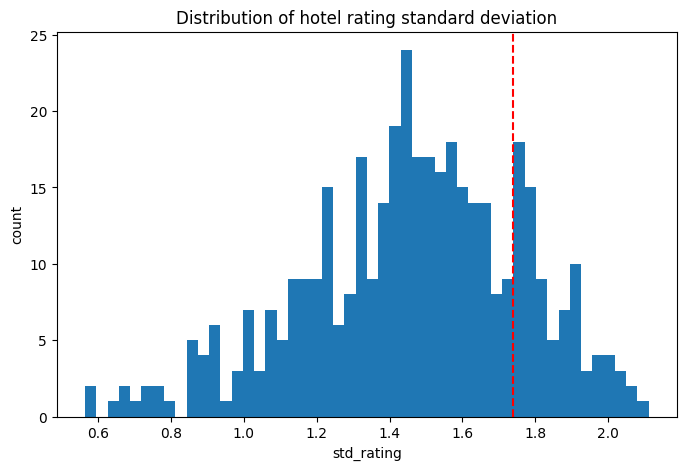

In [18]:
import matplotlib.pyplot as plt
plt.hist(hotel_stats["std_rating"].dropna(), bins=50)
plt.axvline(json.load(open("config.json"))["epsilon_value"], color="red", linestyle="--")
plt.title("Distribution of hotel rating standard deviation")
plt.xlabel("std_rating")
plt.ylabel("count")
plt.show()

In [19]:
import os
import sqlite3
import pandas as pd
from pathlib import Path

# --- Configuration ---
DB_FOLDER = os.path.join(os.getcwd(), "DB_Output")
os.makedirs(DB_FOLDER, exist_ok=True)

DB_PATH = os.path.join(DB_FOLDER, "project_data.db")
conn = sqlite3.connect(DB_PATH)

# --- Collect all output files ---
all_files = [
    os.path.join(OUTPUT_DIR, f)
    for f in os.listdir(OUTPUT_DIR)
    if f.lower().endswith((".csv", ".xlsx", ".parquet"))
]

print(f"Found {len(all_files)} files to save in DB.")

# --- Loop through and save each file as a SQL table ---
for file_path in all_files:
    file_name = Path(file_path).stem
    try:
        if file_path.endswith(".csv"):
            df = pd.read_csv(file_path)
        elif file_path.endswith(".xlsx"):
            df = pd.read_excel(file_path)
        elif file_path.endswith(".parquet"):
            df = pd.read_parquet(file_path)
        else:
            print(f"Skipping unsupported file: {file_name}")
            continue

        df.to_sql(file_name, conn, if_exists="replace", index=False)
        print(f"✅ Saved: {file_name} → table '{file_name}'")

    except Exception as e:
        print(f"⚠️ Error saving {file_name}: {e}")

conn.commit()
conn.close()

print(f"\n✅ All data successfully saved to: {DB_PATH}")
print("Each file is now a table you can query with SQL.")

Found 8 files to save in DB.
✅ Saved: ontology_counts → table 'ontology_counts'
✅ Saved: D1_step1_sentiment → table 'D1_step1_sentiment'
✅ Saved: negative_top_words → table 'negative_top_words'
✅ Saved: D1_with_ambiguous → table 'D1_with_ambiguous'
✅ Saved: D1_with_empath → table 'D1_with_empath'
✅ Saved: positive_top_words → table 'positive_top_words'
✅ Saved: D1_final → table 'D1_final'
✅ Saved: by_hotel_stats → table 'by_hotel_stats'

✅ All data successfully saved to: /Users/noman/Desktop/DB_Output/project_data.db
Each file is now a table you can query with SQL.
